# Interactive learning "Active learning" 


This is a playground for an active learning setting for the course [interactive learning](https://www.mah.se/upload/FAKULTETER/TS/Forskning/Kursplan%20Interaktiv%20maskininl%C3%A4rning.pdf). Active learning is characterized in the way that it is a problem that is between supervised and unsupervised learning. We have some labelled data but the majority of the data is [unlabeled](https://en.wikipedia.org/wiki/Active_learning_(machine_learning)). 

The setup is inspired and by the article [Active Learning With Drifting Streaming Data](https://ieeexplore.ieee.org/document/6414645). 
For the machine learning the framework from [fast.ai](http://www.fast.ai/) is used, that framwork is an exptension off [pytorch](https://pytorch.org/). A lot of inspiration for this is taken from the first lesson at [fastai](http://course.fast.ai/)

### The problem
In the example below where a mockup is built for sorting batteries. The batteries comes into the system and decisions has to be made to sort batteries as chargeable or alkaline. There is no going back and resort the batteries. Since the incoming batteries can be dirty or of an previously unseen brand and type classification can be problematic. There needs to be a way to update the classifier so it can handle the changes in incoming batteries. As such it is a typical active learning problem. To be able to quatnify the results we need a budget, a cost for labeling and a penalty for wrongly sorted battereries. Total budget and labelling cost is easy to estimate but the penalties on wrongy sorted batteries is a more complicated figure that probably has to be estimated by manual inspection of the sorted material. Another source of error is that alkaline batteries are much more common that chargeable and that it is worse to sort chargeable as alkaline the the other way around. 

### Machine learning algorithm
In this mockup a CNN (Convolutional Neural Network) is used to sort the batteries. CNN's is preferable used to classify images, in this case we use a pretrained model [resnet-34](https://www.kaggle.com/pytorch/resnet34) as a start. In this test we only use a less than 100 images to retrain the model so it can be used for prediction. In this case we have taken around 5 images on each battery fro different angels and devided them in train,validation and test set. Test set is around 30% of all images. The rest of the data is labeled data (70% of total data) is divided as 70% training set and 30% validatation set.   

![setup][setupimg]
_A visualisation of the setup, the batteries moves forward on the conveyer belt, the camera takes images and decides first if the batteriy should be labeled and second if it should be sorted as chargeable (contains Pb,Cd,Ni,Hg) or as an alkaline batteryalkaline._

### Exploration
We can expect context drift both abrupt when completely new batteri brands enter and also gradually when designand coloring of brands change. This indicates that we need a strategi to label some of the batteries that comes in using some kind of algotrithm. In this seminar we use active learning and then the algorithm should select the batteries to be labelled.

In the [article](https://ieeexplore.ieee.org/document/6414645) we use as inspiration four strategies are outlined that balance explotation and exploration to select batteries to label. We have implemented two one random (exploration)  and one based on accuracy (explotation). Other algorithms combine the strategies and balance exploration and explotation.

### Metric
Seminar 2 on active learning with example sorting batteries in 2 classes "alkaline" and "chargeable". As in a real world problem

### Some information around sorting
As a real world solution that uses machine learning to sort batteries can be seen here [film](https://www.youtube.com/watch?feature=player_embedded&v=OugqnVO7WiU). And som infomationaround the problem i [general (in swedish](https://www.sopor.nu/fakta-om-sopor/vad-haender-med-din-sopa/elavfall/batterier)

[setupimg]: /tree/storage/images/setup.jpg "Setup"


In [15]:
# Som get started crap run this first
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
import sys
import zipfile
import platform
####sys.path.append("../../coursesinteractive")
from fastai.imports import *
print(platform.python_version())
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
# set some variables
PATH = "/storage/myData/batteries/"
arch=resnet34  ##Using the resnet34 model
sz=224
print(f'NVidia GPUs is called CUDA aviable {torch.cuda.is_available()}')
print(f'deep learning accelerator aviable CuDNN {torch.backends.cudnn.enabled}')



3.6.5
NVidia GPUs is called CUDA aviable True
deep learning accelerator aviable CuDNN True


## Utility functions
Run this to unpack images that will be used for learning.

In [3]:
#Unpack images from zipfile to data lib
#% rm -rf (mydata/tools
with zipfile.ZipFile("/storage/myData/batteries.zip","r") as zip_ref:
    zip_ref.extractall("/storage/myData")


## Train batteries

In [5]:
# Uncomment below if you need to reset your precomputed activations
#shutil.rmtree(f'{PATH}tmp', ignore_errors=True)
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), test_name="test")
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 12)
# prints training loss, validation loss and accuracy
learn.save("batteries_1")

epoch      trn_loss   val_loss   accuracy        
    0      0.992586   0.624568   0.666667  
    1      0.777632   0.571024   0.592593        
    2      0.706467   0.551934   0.666667        
    3      0.577279   0.494517   0.703704        
    4      0.495123   0.412703   0.814815        
    5      0.469237   0.364542   0.851852        
    6      0.411479   0.301733   0.851852        
    7      0.414098   0.297774   0.925926        
    8      0.385571   0.272757   0.925926        
    9      0.346039   0.250379   0.925926        
    10     0.315576   0.237585   0.925926        
    11     0.295788   0.222992   0.925926        



## View training and validation set for batteries

In [6]:
# Run to register the plot functions
#And I know verbose.....
def plot_images_from_train_set(train_y):
    imgs=[]
    titles=[]
    res = np.extract(data.trn_y==train_y,data.trn_ds.fnames)
    printmd("# "+data.classes[train_y]+"s in training set")
    for i in range(0,len(res)):
        title = res[i]
        #print(title)
        imgs.append(plt.imread(PATH + res[i]))
        titles.append(title)    
    return plots(imgs,titles=titles,rows=5,figsize=(20,16))

def plot_images_from_val_set(val_y):
    imgs=[]
    titles=[]
    res = np.extract(data.val_y==val_y,data.val_ds.fnames)
    printmd("# "+data.classes[val_y]+"s in validation set")
    for i in range(0,len(res)):
        title = res[i]
        #print(title)
        imgs.append(plt.imread(PATH + res[i]))
        titles.append(title)    
    return plots(imgs,titles=titles,rows=5,figsize=(20,16))

print("The classes: "+str(data.classes))
print("And the validation set alkaline is 0 and chargeable is 1:" +str(data.val_y))

The classes: ['alkaline', 'chargeable']
And the validation set alkaline is 0 and chargeable is 1:[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]


# alkalines in training set

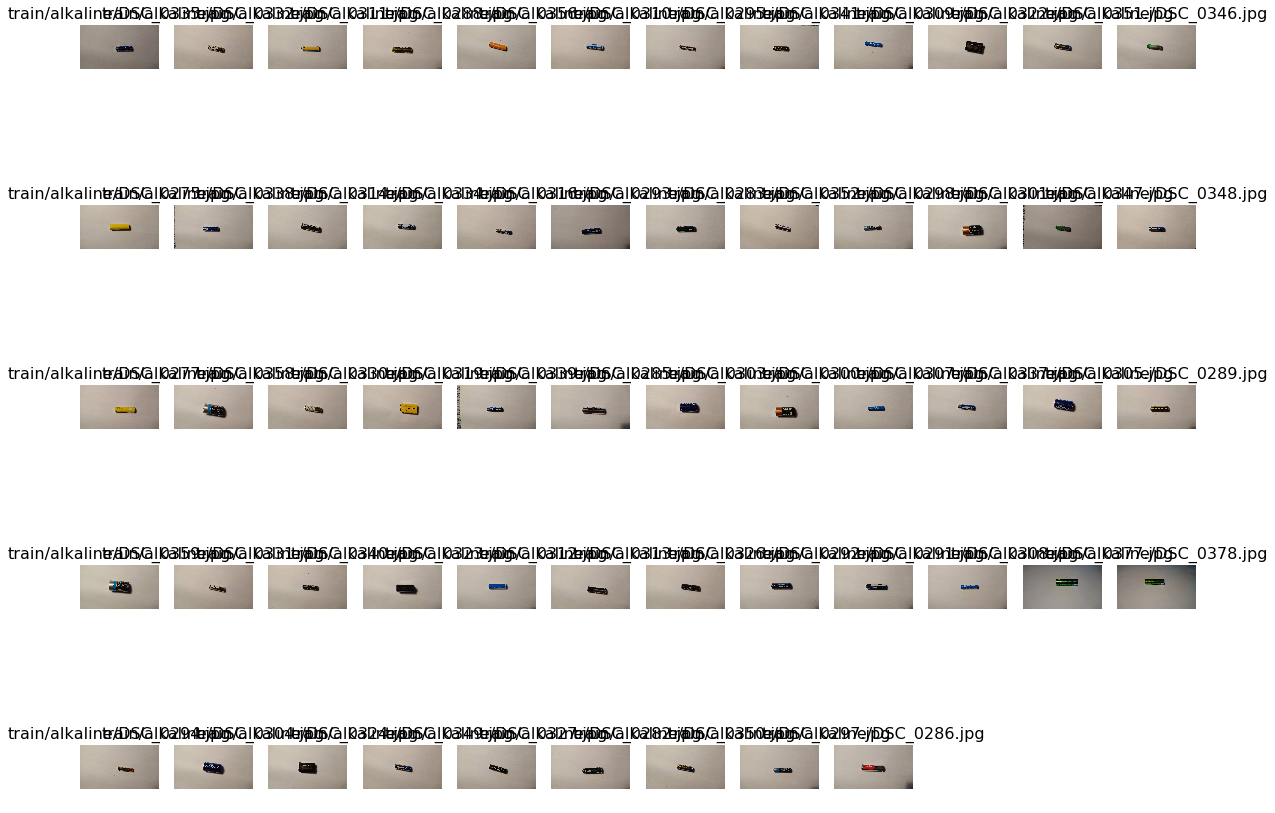

In [7]:
#Alkalines
plot_images_from_train_set(0)

# chargeables in training set

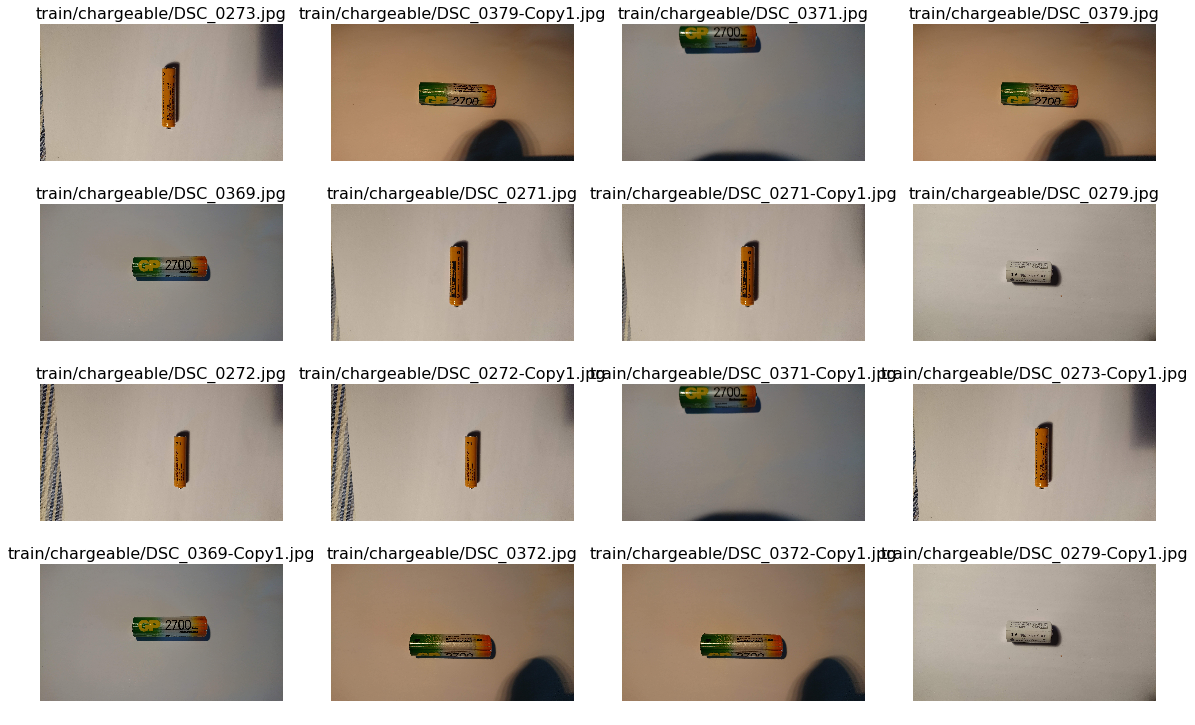

In [9]:
#Chargeables
plot_images_from_train_set(1)

# alkalines in validation set

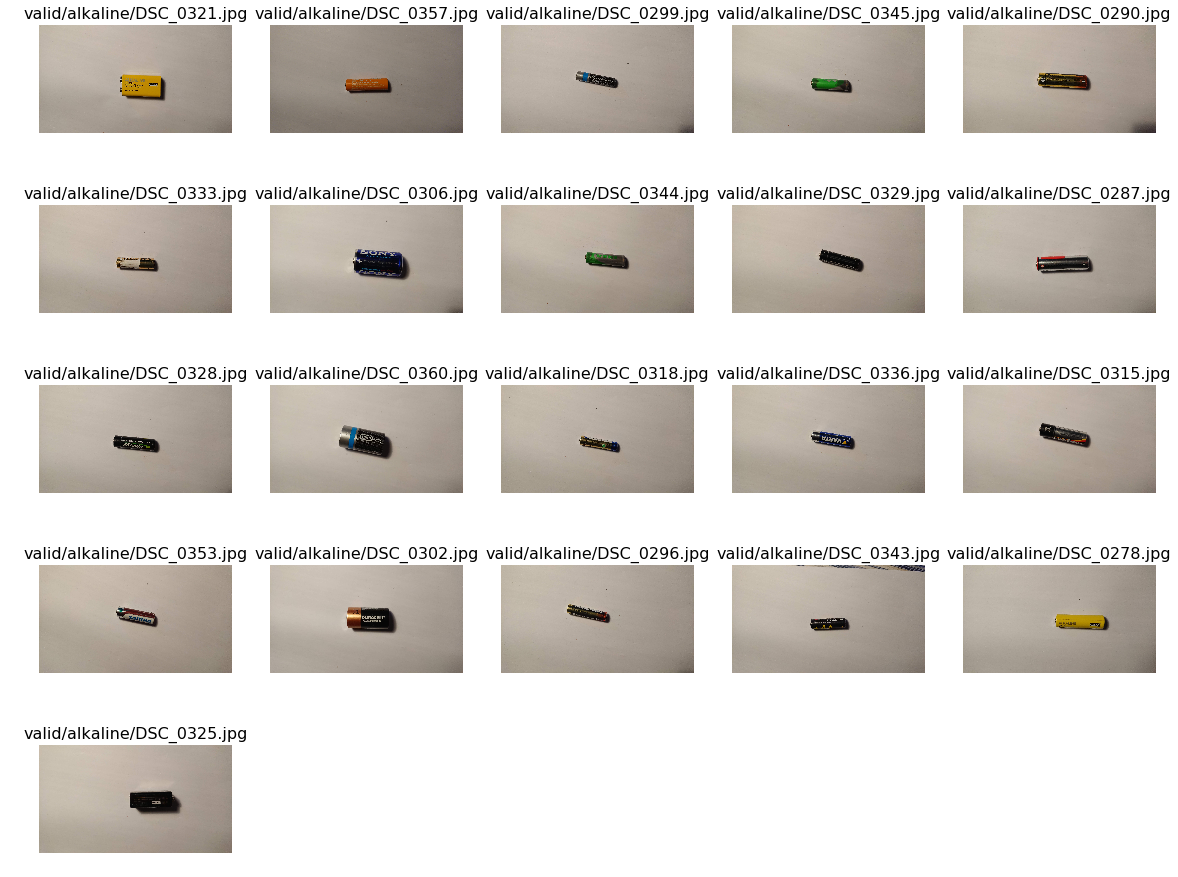

In [7]:
#Alkalines
plot_images_from_val_set(0)

# chargeables in validation set

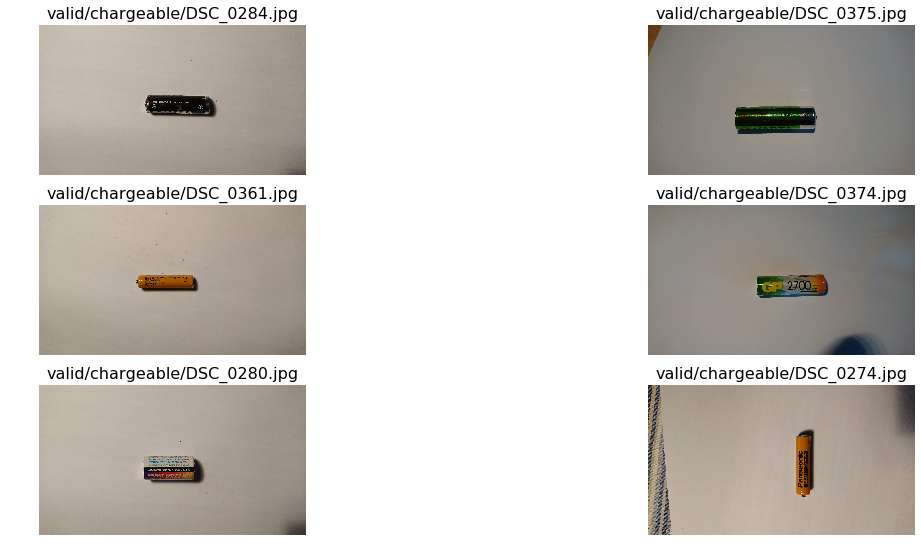

In [8]:
#Chargeables
plot_images_from_val_set(1)

## Confusion matrix 

[[20  1]                             
 [ 1  5]]


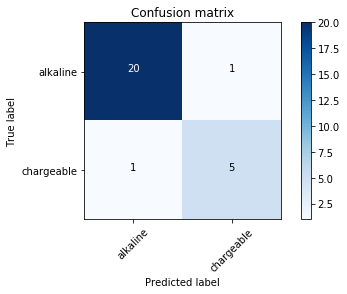

In [7]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
from sklearn.metrics import confusion_matrix
#accuracy_np(probs, y)
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

## Predictions on test set

Sorted in accuracy order, closer to 0 the model belives it is a plier, closer to 1 the model belives it is a screwdriver. 
So now we will know if it overfitted or included variance/bias.

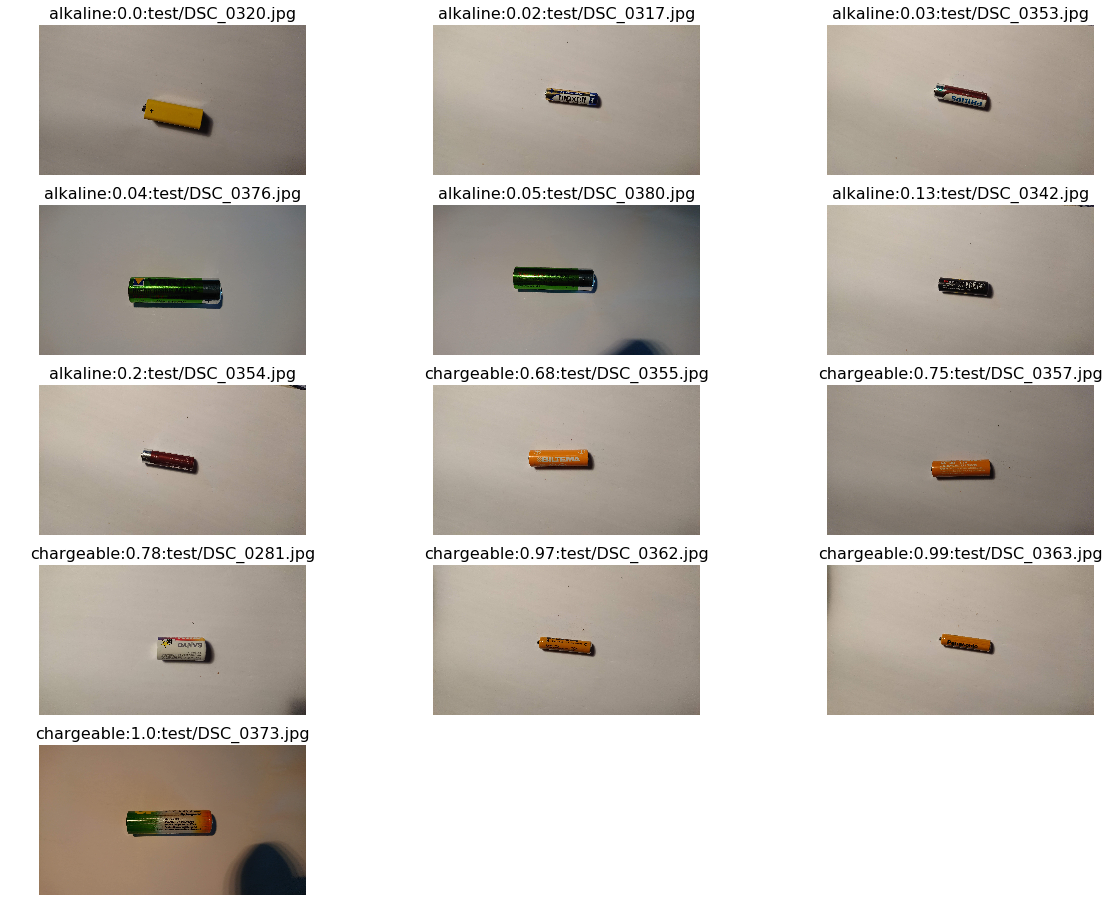

In [9]:
def plot_predictions_in_accuacy_order():
    log_preds=learn.predict(is_test=True) 
    #probs = np.round(np.exp(log_preds[:,1])*100,decimals=0) ##Convert result from log scale (probs given in log...)
    probs = np.exp(log_preds[:,1])
    names = data.test_ds.fnames
    probs_sorted = np.sort(probs)
    #print(probs)
    #print(names)
    img_names_sorted_on_probs = [x for _,x in sorted(zip(probs,names))]
    img = []
    titles = []
    for i in range(0,len(data.test_ds.fnames)):
    #for i in range(0,4):
        title = PATH + img_names_sorted_on_probs[i]
        img.append(plt.imread(title))
        titles.append(data.classes[int(probs_sorted[i]+0.5)]+":"+str(np.around(probs_sorted[i],decimals=2))+":"+img_names_sorted_on_probs[i])    
    return plots(img,titles=titles,rows=5,figsize=(20,16))

plot_predictions_in_accuacy_order()